# Xe Propellant Storage
Can metal-organic frameworks (MOFs) confer a benefit for storing Xe? For applications as propellant for a spacecraft, the goal is to minimize the total mass carried into space. To contrast the competeing setups, the total mass being lifted is composed of the following:
- for compressed Xe (`cXe`) storage (no MOF, a free-space tank): the xenon needed and the material that composes the tank
- for adsorbed Xe (`aXe`) storage (a tank packed with MOF): the xenon needed, the material that composes the tank *and* the adsorbent material.

The idea is that we can reduce the amount of required tank material by lowering the pressure needed to store a given density (mass?) of Xe via the implimentation of MOFs. The tradeoff is, however, that the MOF material will also have to be carried in the tank. Therefore, the question is whether the reduced mass of the tank material outweighs the extra mass of this adsorbent material being into space.


Chung's MoF Database with cif files for simulated clean Mofs [link](https://zenodo.org/record/3370144)

In [2]:
using PyPlot
using PorousMaterials
using CSV
using DataFrames
using JSON
using Printf

PyPlot.matplotlib.style.use("Solarize_Light2")

rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 16 ;

The xenon gas is stored in the tank at room temperature `T` before launch. (still cannot find a source for this, but it seems that there simply isn't a temperature controll system specifically for the xenon tanks on the ground of in orbit, so they are simply at ambient temperature; howwever, I did read that as the tank is being filled that they have to controll the fill rate in order to not exceed the tanks range of operable temperatures which is capped at $55^oC$ according to the source listed below.

[1] Tam,  W.;  Jackson,  A.;  Nishida,  E.;  Ka-sai, Y.; Tsujihata, A.; Kajiwara, K. Designand  manufacture  of  the  ETS  VIII  xenontank.36thAIAA/ASME/SAE/ASEEJoint  Propulsion  Conference  and  Exhibit.2000; p 3677.(https://doi.org/10.2514/6.2000-3677)

[2] Welsch,  G.;  Boyer,  R.;  Collings,  E.Materials properties handbook: titanium alloys;ASM international, 1993. 

[3] Niinomi,   M.   Mechanical   properties   of biomedical  titanium  alloys. Materials Science and Engineering: A1998,243, 231–236.

[4] propellant storage considerations [link](https://erps.spacegrant.org/uploads/images/images/iepc_articledownload_1988-2007/1991index/IEPC1991-107.pdf)

The ambient temperature oof the craft is assumed to be ~300K when it is in orbit [4].
Additionally, the tanks opperating temperatures are listed as $278K-328K (5^oC -55^oC)$ [1]

In [3]:
const temperature = 298.0; # K 

The typical amount of super critical Xe to bring into space per tank is 89 kg [1].

In [4]:
xe_atomic_mass = read_atomic_masses()[:Xe] # in g / mol

mass_desired_xe_propellant = 89.0 # kg Xe
mol_desired_xe_propellant = mass_desired_xe_propellant * 1000 / xe_atomic_mass # mol Xe

677.8731539381383

Properties of anealed Ti-6Al-4V (tank material):

We model the pressure vessel as a thin-walled pressure vessel where the density `ρ` and yield strength `σ` of the tank material are listed below.

Ti-6Al-4V is the titanium alloy that is most commonly used tank shell material [1]. The numbers below are from [ASM](http://asm.matweb.com/search/SpecificMaterial.asp?bassnum=MTP641) webpage are in good agreement with the published values [2],[3]. 

In [5]:
# # Kevlar 49 Source: http://www.mse.mtu.edu/~drjohn/my4150/props.html
# const ρ_tank_material = 1470.0 # kg/m³
# const σ_tank_material = 28000.0 # bar

const ρ_tank_material = 4428.785 # kg/m³ (convdrted from 0.16 lb/in³ listed in [2])
const σ_tank_material = 8250.0 # bar Yield Strength (lower-limit of reported values [3])

8250.0

To justify our range of considered pressures: the range of storage pressures considered goes from an empty tank at 0 bar to well above the maximum expected operating pressure (MEOP) described in the technichal report as 150 bar [1].

## xenon gas properties

Source for experimental data for (real) xenon gas: [NIST](https://webbook.nist.gov/cgi/fluid.cgi?Action=Data&Wide=on&ID=C7440633&Type=IsoTherm&Digits=5&PLow=0&PHigh=350&PInc=0.01&T=298.00&RefState=DEF&TUnit=K&PUnit=bar&DUnit=mol%2Fl&HUnit=kJ%2Fmol&WUnit=m%2Fs&VisUnit=uPa*s&STUnit=N%2Fm). Load in NIST data on xenon at 298 K. source for critical pressure [here](https://webbook.nist.gov/cgi/fluid.cgi?T=298.0&PLow=&PHigh=&PInc=&Applet=on&Digits=5&ID=C7440633&Action=Load&Type=IsoTherm&TUnit=K&PUnit=bar&DUnit=mol%2Fl&HUnit=kJ%2Fmol&WUnit=m%2Fs&VisUnit=uPa*s&STUnit=N%2Fm&RefState=DEF)

In [17]:
wheres_nist_xenon_data = joinpath("data", "NIST_data", "xenon_NIST_data.txt")

df_xe_data = CSV.read(wheres_nist_xenon_data)

# source: NIST 
const xe_critical_pressure = 58.420 # bar

# put density in units we're working with (mol/m³)
insertcols!(df_xe_data, 3, density_mol_m3=df_xe_data[:, Symbol("Density (mol/l)")] * 1000.0)
rename!(df_xe_data, :density_mol_m3 => Symbol("Density (mol/m³)"))

first(df_xe_data, 5)

,Temperature (K),Pressure (bar),Density (mol/m³),Density (mol/l),Volume (l/mol)
,Float64,Float64,Float64,Float64,String
1,298.0,0.0,0.0,0.0,infinite
2,298.0,0.58333,23.615,0.023615,42.346
3,298.0,1.1667,47.376,0.047376,21.108
4,298.0,1.75,71.284,0.071284,14.028
5,298.0,2.3333,95.342,0.095342,10.489


For convenience, we define our array of pressures to use in the study as those in the NIST data and get the corresponding densities of the (real) xenon gas.

In [7]:
const pressures = df_xe_data[:, Symbol("Pressure (bar)")][2:end] # bar
const ρ_xe = df_xe_data[:, Symbol("Density (mol/m³)")][2:end]; # mol/m³

get density of ideal gas at our array of `pressures` for comparison.

In [8]:
# Universal Gas Constant:
const R = 8.3144598e-5; # m³-bar/(K-mol)
# ideal gas density
ρ_ideal_gas = pressures / (R * temperature); # mol / m³

plot the density of real gas at our array of `pressures`.

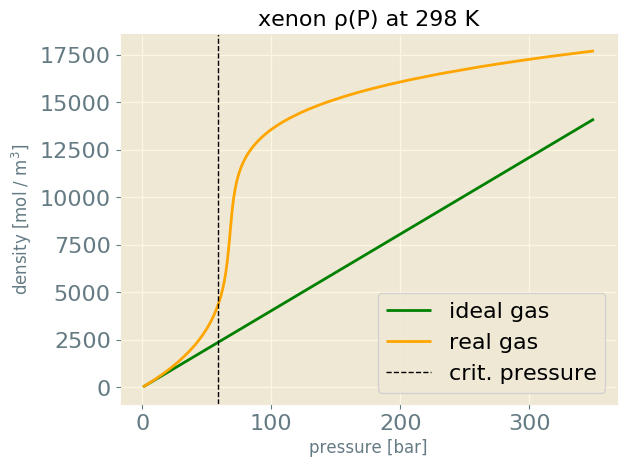

In [19]:
figure()
plot(pressures, ρ_ideal_gas, color="green", label="ideal gas")
plot(pressures, ρ_xe, 
    color="orange", label="real gas")
xlabel("pressure [bar]")
axvline(x=xe_critical_pressure, linestyle="--", color="k", label="crit. pressure", lw=1)
ylabel("density [mol / m\$^3\$]")
legend()
title("xenon ρ(P) at 298 K")
savefig("xenon_gas_density.pdf", format="pdf")

## Compressed xenon (`cXe`) storage

The premise is that we are storing some quantity `mol_desired_xe_propllant` at a specified `temperature`.

For all arrays below, element `i` represents the parameters when we choose to store at `pressures[i]` (bar); for example, `V_cXe_tank[i]` is the volume of the tank required to store the desired quantity `mol_desired_xe_propllant` (mol) of Xe at 298 K and pressure `pressures[i]` bar.

The interior volume of the tank must be equal to the volume of propellant (of course). Since we have the density of the propellant at each pressure, we thus know the volume of the tank at each choice of storage pressure.

In [11]:
volume_cxe_tank = mol_desired_xe_propellant ./ ρ_xe; # m³

Assuming the tank is spherical, we can calculate the radius of the tank for each choice of storage pressure.

In [13]:
radius_cxe_tank = (volume_cxe_tank * 3 / (4 * π)) .^ (1 / 3); # m

We apply the thin-walled tank stress model to obtain the minimum wall thickness required to contain the pressure of the compressed xenon. Thickness is found using the free-body diagram of a spherical, thin-walled tank. By taking the force of the fluid over a cross-sectional area ($P \pi  r ^ 2$) set equal to the force of the tank walls over the circumference, including the yield strength and thickness of the wall ($2 \pi  r \sigma  t$). We then isolate $t$ to solve for the thickness.

\begin{equation}
2 \pi  r \sigma  t=P \pi  r ^ 2
\end{equation}

In [14]:
thickness_cxe_tank = pressures .* radius_cxe_tank / (2 * σ_tank_material); # tank wall thickness (m)

The mass of the tank can be found using the surface area of sphere, the thickness of the sphere, and the density of the material.

In [15]:
mass_cxe_tank_material = ρ_tank_material * 4 * π * radius_cxe_tank .^ 2 .* thickness_cxe_tank; # kg

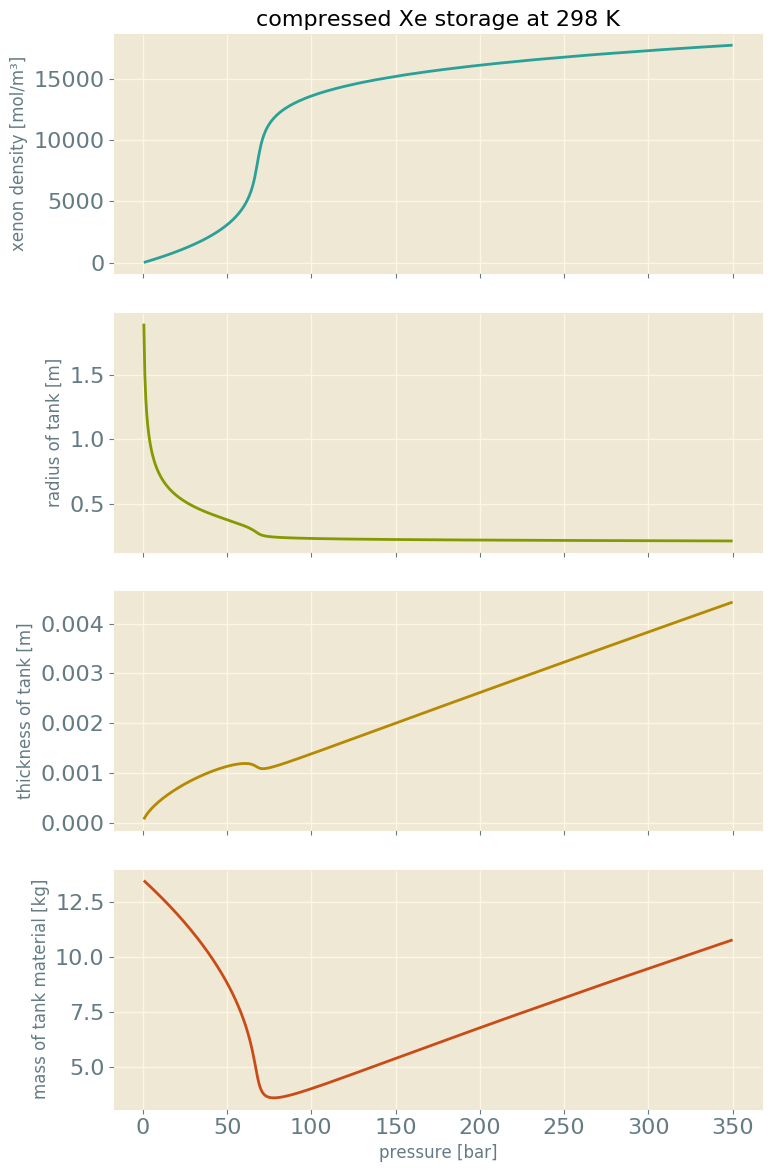

The optimum storage pressure is 77.58 bar with a tank mass of 3.60 kg.optimum: 
	storage pressure [bar] = 77.583
	mass of tank material [kg] = 3.6031983967699857
	tankage fraction [kg] = 0.04048537524460658
	storage density [mol/m³] = 11753.0


PyObject Text(0.5, 28.000000000000007, 'pressure [bar]')

In [27]:
argmin_p_mass = argmin(mass_cxe_tank_material)
@printf("The optimum storage pressure is %.2f bar with a tank mass of %.2f kg.", 
    pressures[argmin_p_mass],mass_cxe_tank_material[argmin_p_mass])

println("optimum: ")
println("\tstorage pressure [bar] = ", pressures[argmin_p_mass])
println("\tmass of tank material [kg] = ", mass_cxe_tank_material[argmin_p_mass])
println("\ttankage fraction [kg] = ", mass_cxe_tank_material[argmin_p_mass] / mass_desired_xe_propellant)
println("\tstorage density [mol/m³] = ", ρ_xe[argmin_p_mass])


fig, axs = subplots(4, 1, figsize=(8, 12), 
                    sharex=true, sharey=false, tight_layout=true)

axs[1].plot(pressures, ρ_xe, color="C1")
axs[1].set_ylabel("xenon density [mol/m³]")
axs[1].set_title("compressed Xe storage at 298 K")

axs[2].plot(pressures, radius_cxe_tank, color="C2")
axs[2].set_ylabel("radius of tank [m]")

axs[3].plot(pressures, thickness_cxe_tank, color="C3")
axs[3].set_ylabel("thickness of tank [m]")
# axs[3].axvline(x=xe_critical_pressure, linestyle="--", color="k", label="crit. pressure", lw=1)

axs[4].plot(pressures, mass_cxe_tank_material, color="C4")
axs[4].set_ylabel("mass of tank material [kg]")


xlabel("pressure [bar]")

$\checkmark$ compare tankage fraction to previous work [here](https://erps.spacegrant.org/uploads/images/images/iepc_articledownload_1988-2007/1991index/IEPC1991-107.pdf). optimum tankage fraction in this work is around 0.065. <br>
$\checkmark$ compare optimum storage pressure to previous work [here](https://erps.spacegrant.org/uploads/images/images/iepc_articledownload_1988-2007/1991index/IEPC1991-107.pdf). the  optimum storage density in this work is around 9900 mol/m$^3$= 1.3 g/mL.

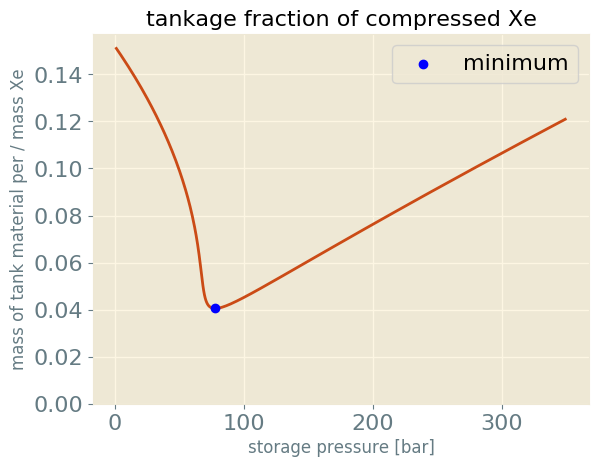

PyObject Text(0.5, 1, 'tankage fraction of compressed Xe')

In [23]:
tankage_fraction = mass_cxe_tank_material ./ mass_desired_xe_propellant

figure()
plot(pressures,tankage_fraction,color="C4")
scatter(pressures[argmin_p_mass],tankage_fraction[argmin_p_mass],label="minimum",color="b",zorder=999)

xlabel("storage pressure [bar]")
ylabel("mass of tank material per / mass Xe")
legend()
ylim(ymin=0.0)
title("tankage fraction of compressed Xe")
#savefig("Xenon van der Waals Gas in Titanium.pdf", format="pdf")

# Adsorbed xenon `aXe` storage

**TODO**: Get adsorption isotherm data at 298K for the MOFS being used and/convert check their units.

create an array of the crystals we are considering.

In [50]:
crystal_names = ["SBMOF-1", "CC3", "IRMOF-1", "Ni-MOF-74", "HKUST-1", "SBMOF-2", "Co-formate",
             "ZincTetrazolate", "FMOF-Cu", "MOF-505", "PCN-14"]

11-element Array{String,1}:
 "SBMOF-1"        
 "CC3"            
 "IRMOF-1"        
 "Ni-MOF-74"      
 "HKUST-1"        
 "SBMOF-2"        
 "Co-formate"     
 "ZincTetrazolate"
 "FMOF-Cu"        
 "MOF-505"        
 "PCN-14"         

#### compute crystal densities of the materials

In [59]:
# create a dictionary to store the crystal density values
ρ_crystal = Dict{String, Float64}()

# find crystal density using PorousMaterials.jl
for crystal_name in crystal_names
    framework = Framework(crystal_name * ".cssr")
    strip_numbers_from_atom_labels!(framework)
    ρ_crystal[crystal_name] = crystal_density(framework) # kg/m³
end

ρ_crystal # kg/m³

Dict{String,Float64} with 11 entries:
  "Ni-MOF-74"       => 1194.12
  "SBMOF-2"         => 1191.92
  "ZincTetrazolate" => 1128.47
  "PCN-14"          => 871.051
  "MOF-505"         => 926.618
  "Co-formate"      => 1821.5
  "IRMOF-1"         => 593.307
  "CC3"             => 958.585
  "HKUST-1"         => 879.096
  "FMOF-Cu"         => 1619.15
  "SBMOF-1"         => 1570.4

#### read in experimental adsorption isotherm data 

In [60]:
path_to_isotherms = joinpath("data", "exptl_xe_isotherms")

"data/exptl_xe_isotherms"

In [63]:
xe_isotherms = Dict{String, DataFrame}()

for crystal_name in crystal_names
    isotherm_filename = joinpath(path_to_isotherms, crystal_name, "Xe.csv")
    xe_isotherms[crystal_name] = CSV.read(isotherm_filename)
end
xe_isotherms["CC3"]

,P(mbar),L(mmol/g)
,Float64,Float64
1,1015.85,2.42208
2,948.619,2.40909
3,900.355,2.38961
4,814.17,2.35065
5,734.878,2.31818
6,700.403,2.30519
7,655.594,2.27273
8,584.923,2.24026
9,574.586,2.22727


In [19]:
# This seems to work though...?
df_sbmof2 = isotherm_data("SBMOF-2.json");

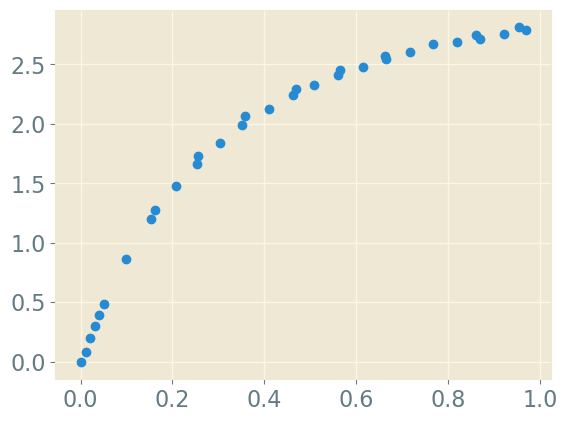

PyObject <matplotlib.collections.PathCollection object at 0x7fbfaa6a7240>

In [20]:
figure()
scatter(df_sbmof2[:, Symbol("P(bar)")],df_sbmof2[:, Symbol("Adsorption(mmol/g)")])

## Convert isotherms to same units

Here we convert to common units: P (bar) and Adsorption (mol/m³)

In [21]:
# All of the data being used is based on simulated data based on the clean .cif files that were also used 
# to calculate the crystal densities above


dict_isotherms= Dict{AbstractString, DataFrame}()
isotherms = readdir(joinpath(pwd(), "data", "isotherms"))


df_CC3 = CSV.read(joinpath(pwd(), "data", "isotherms", "CC3_298K.csv"))
df_CC3[!, Symbol("P(bar)")] = df_CC3[!, Symbol("P(mbar)")] / 1000; # bar
df_CC3[!, :mol_m3] = df_CC3[!, Symbol("L(mmol/g)")] * df_ρ_crystal[Symbol("CC3")] # mol/m^3
dict_isotherms["CC3"] = df_CC3

df_Co_formate = CSV.read(joinpath(pwd(), "data", "isotherms", "Co_formate_298K.csv"))
df_Co_formate[!, :mol_m3] = df_Co_formate[!, Symbol("L(mmol/g)")] * df_ρ_crystal[Symbol("Co-formate")]; # mol Xe/m³ MOF
dict_isotherms["Co-formate"] = df_Co_formate

df_MOF_505 = CSV.read(joinpath(pwd(), "data", "isotherms", "MOF_505_292K.csv"))
df_MOF_505[!, :mol_m3] = df_MOF_505[!, Symbol("Adsorption(mmol/g)")] * df_ρ_crystal[Symbol("MOF-505")];# mol Xe/m³ MOF
dict_isotherms["MOF-505"] = df_MOF_505

df_Ni_MOF_74 = CSV.read(joinpath(pwd(), "data", "isotherms", "Ni_MOF_74_297K.csv"))
df_Ni_MOF_74[!, Symbol("P(bar)")] = df_Ni_MOF_74[!, Symbol("P(mbar)")] / 1000; # bar
df_Ni_MOF_74[!, :mol_m3] = df_Ni_MOF_74[!, :PercentMass] / 100.0 * 1000.0 * df_ρ_crystal[Symbol("Ni-MOF-74")] / xe_atomic_mass; # mol Xe/m³ MOF
dict_isotherms["Ni-MOF-74"] = df_Ni_MOF_74

df_SBMOF_1 = CSV.read(joinpath(pwd(), "data", "isotherms", "SBMOF_1_298K.csv"))
df_SBMOF_1[!, Symbol("P(bar)")] = df_SBMOF_1[!, Symbol("P(mbar)")] / 1000; # bar

# mass % = (measured mass -  dry sample mass) / (dry sample mass) * 100.
# (g Xe / g MOF) * (1000 g MOF/ 1 kg MOF) * (ρ_MOF kg MOF/m³ MOF) * (1 mol Xe/ MW g Xe)
df_SBMOF_1[!, :mol_m3] = df_SBMOF_1[!, :PercentMass] / 100.0 * 1000.0 * df_ρ_crystal[Symbol("SBMOF-1")] / xe_atomic_mass; # mol Xe/m³ MOF  
dict_isotherms["SBMOF-1"] = df_SBMOF_1

df_SBMOF_2 = CSV.read(joinpath(pwd(), "data", "isotherms", "SBMOF_2_298K.csv"))
df_SBMOF_2[!, Symbol("P(bar)")] = df_SBMOF_2[!, Symbol("P(torr)")] / 750.062
df_SBMOF_2[!, :mol_m3] = df_SBMOF_2[!, Symbol("L(ccSTP/g)")] / 22.4 * df_ρ_crystal[Symbol("SBMOF-2")];
dict_isotherms["SBMOF-2"] = df_SBMOF_2

df_CROFOUR_1_Ni = CSV.read(joinpath(pwd(), "data", "isotherms", "CROFOUR_1_Ni_298K.csv"))
df_CROFOUR_1_Ni[!, Symbol("P(bar)")] =  df_CROFOUR_1_Ni[!, Symbol("P(kPa)")] / 100
df_CROFOUR_1_Ni[!, :mol_m3] = df_CROFOUR_1_Ni[!, Symbol("L(ccSTP/g)")] / 22.4 * df_ρ_crystal[Symbol("CROFOUR-1-Ni")];
dict_isotherms["CROFOUR-1-Ni"] = df_CROFOUR_1_Ni

dict_isotherms

Dict{AbstractString,DataFrame} with 7 entries:
  "Ni-MOF-74"    => 14×4 DataFrame…
  "SBMOF-2"      => 39×4 DataFrame…
  "CC3"          => 27×4 DataFrame…
  "CROFOUR-1-Ni" => 234×4 DataFrame…
  "SBMOF-1"      => 16×5 DataFrame…
  "MOF-505"      => 15×3 DataFrame…
  "Co-formate"   => 25×3 DataFrame…

read in xenon adsorption data.

In [23]:
# df_MOF = CSV.read(joinpath(pwd(), "data", "isotherms", "SBMOF_1_298K.csv"))
# df_MOF[!, Symbol("P(bar)")] = df_MOF[!, Symbol("P(mbar)")] / 1000 # bar
# # mass % = (measured mass -  dry sample mass) / (dry sample mass) * 100.
# # (g Xe / g MOF) * (1000 g MOF/ 1 kg MOF) * (ρ_MOF kg MOF/m³ MOF) * (1 mol Xe/ MW g Xe)
# df_MOF[!, :mol_m3] = df_MOF[!, :PercentMass] / 100.0 * 1000.0 * ρ_MOF / read_atomic_masses()[:Xe] # mol Xe/m³ MOF  
# df_MOF

In [29]:
# # filter through units with Arni l8er
# global PATH_TO_DATA = joinpath(pwd(), "data/isotherms/")

# function isotherm_data(isotherm_filename::AbstractString)
#     file = open(joinpath(PATH_TO_DATA, isotherm_filename))
#     lines = readlines(file)
#     close(file)
#     data = JSON.parse(join(lines))
    
#     pressure_pts = Array{Float64,1}()
#     adsorption_pts = Array{Float64,1}()

#     for datapoints_dict in data["isotherm_data"]
#         append!(pressure_pts, datapoints_dict["pressure"])
#         append!(adsorption_pts, datapoints_dict["total_adsorption"])
#     end

#     df_isotherm = Dict{Symbol, Array{Float64}}()
#         df_isotherm[Symbol("P(bar)")] = pressure_pts
#         df_isotherm[Symbol("Adsorption(mmol/g)")] = adsorption_pts
#     DataFrame(df_isotherm)
# end

isotherm_data (generic function with 1 method)

In [54]:
# df = isotherm_data("10.1016j.micromeso.2012.11.013.isotherm1.json")

In [ ]:
# # TODO what MOF?
# const ρ_mof = 555.0 # kg/m³

In [ ]:
# df[!, :mol_m3] = df[!, Symbol("Adsorption(mmol/g)")] * ρ_mof
# showall(df)

## We will now analyze the properties of the tank carrying MOF

Using the function `fit_adsorption_isotherm` from Porous Materials, we calculated `M`, the density of gas in the MOF at saturation, and the Langmuir constant `K`. The Langmuir adsorption model for the loading `L` is:
\begin{equation}
L = M KP/(1+KP)
\end{equation} 

Using thin-walled theory, the thickness of the wall of the container storing the mof is equal to the pressure multiplied by the radius of the container divided by two times the tensile strength of the container material. 
\begin{equation}
t_{tank with mof} = P r_{tank with mof} / 2\sigma
\end{equation} 


In [ ]:
function analyze_adsorbed_xe_tank(P::Array{Float64, 1}, df_MOF::DataFrame, df_ρ::Float64)
    
    #The Langmuir model was then fitted to the experimental data and the root mean square was calculated, showing how good of a fit the model is to the experimental data.
    params_langmuir = fit_adsorption_isotherm(copy(df_MOF), Symbol("P(bar)"), :mol_m3, :langmuir)
    ρ_langmuir = params_langmuir["M"] *  params_langmuir["K"] .* P ./ (1 .+ params_langmuir["K"] .* P)
    
    #The volume of the tank storing the MOF is equal to the volume of the MOF required to store the desired amount of propellant.
    V_aXe_tank = mol_desired_propellant ./ ρ_langmuir # m³
    
    #The mass of the gas stored in the MOF is found using the volume and density of the tank and gas at a pressure.
    m_aXe_gas = ρ_langmuir .* V_aXe_tank .* read_atomic_masses()[:Xe] / 1000 # kg
    
    #Find the corresponding radius of the vessel, assumed spherical.
    r_aXe_tank = (V_aXe_tank * 3 / (4 * π)) .^ (1 / 3) # m
    
    #Mass of MOF needed to carry desired amount of gas.
    m_MOF_needed = V_aXe_tank * df_ρ # kg
    
    #Thin-walled theory 
    t_aXe_tank = P .* r_aXe_tank / (2 * σ_tank_material) # m
    
    #The total mass of the tank and MOF for the desired amount of propellant is equal to the mass of the MOF 
    #required to store the desired amount of propellant, plus the mass of the thin-walled tank storing the MOF.
    m_aXe_tank_material = 4 * π * r_aXe_tank .^ 2 .* t_aXe_tank * ρ_tank_material # kg
    m_aXe_tank = m_MOF_needed .+ m_aXe_tank_material # kg
    
    minimum_index = argmin(m_aXe_tank ./ mass_desired_propellant)
    
    return Dict("Mass of tank material with adsorbed Xe (kg)" => m_aXe_tank_material,
                            "Mass of MOF with adsorbed Xe (kg)" => m_MOF_needed,
                            "Mass of adsorbed Xe tank (kg)" => m_aXe_tank,
                            "Density of gas in MOF (mol/m³)" => ρ_langmuir,
                            "Mass of Xe adsorbed (kg)" => m_aXe_gas,
                            "Minimum index" => minimum_index,
                            "Inner radius (m)" => r_aXe_tank,
                            "Thickness of tank walls (m)" => t_aXe_tank,
                            "Inner volume of tank (m³)" => V_aXe_tank,
                            "Langmuir K" => params_langmuir["K"])
end

dict_aXe = Dict{AbstractString, Dict}()

for crystal in crystals
    dict_aXe[Base.basename(crystal, ".cif")] = analyze_adsorbed_xe_tank(P, dict_isotherms[Base.basename(crystal, ".cif")], df_ρ[Symbol(Base.basename(crystal, ".cif"))])
end

dict_aXe

## Langmuir fit for all mofs

In [ ]:
for crystal in crystals
    figure()
    ax = plt.gca()
    scatter(dict_isotherms[Base.basename(crystal, ".cif")][!, Symbol("P(bar)")],
            dict_isotherms[Base.basename(crystal, ".cif")][!, :mol_m3], color="b",
            label=Base.basename(crystal, ".cif") * " experimental data")
    lim = ax.get_xlim()
    plot(P, dict_aXe[Base.basename(crystal, ".cif")]["Density of gas in MOF (mol/m³)"], color="g",
            label="Langmuir fit")
    xlabel("Pressure [bar]")
    ylabel("Adsorption [mol/m³]")
    ax.set_xlim(lim)
    title(Base.basename(crystal, ".cif"))
    legend()
    #savefig(Base.basename(crystal, ".cif") * " Langmuir fit")
end

## adsorbed xenon storage for each MOF

In [ ]:
for crystal in crystals
    figure()
    plot(P, dict_aXe[Base.basename(crystal, ".cif")]["Mass of adsorbed Xe tank (kg)"] / 
        mass_desired_propellant, color="C4", lw=3, label=Base.basename(crystal, ".cif") * " total")
    plot(P, dict_aXe[Base.basename(crystal, ".cif")]["Mass of MOF with adsorbed Xe (kg)"] / 
        mass_desired_propellant, color="C4", label=Base.basename(crystal, ".cif"), linestyle="--")
    plot(P, dict_aXe[Base.basename(crystal, ".cif")]["Mass of tank material with adsorbed Xe (kg)"] / 
        mass_desired_propellant, color="C4", label=Base.basename(crystal, ".cif") * " tank material", linestyle="-.")
    xlabel("storage pressure [bar]")
    ylabel("tankage fraction [kg material / kg propellant]")
    title("adsorbed Xe storage")
    ax = gca()
    ax.set_xscale("log")
    legend()
end

## juxtapose compressed vs adsorbed xenon storage

In [ ]:
for crystal in crystals
    figure()
    plot(real_gas[!, Symbol("Pressure (bar)")], m_cXe_tank_material / mass_desired_propellant, color="C0", label="(cXe) total = tank material")

    plot(P, dict_aXe[Base.basename(crystal, ".cif")]["Mass of adsorbed Xe tank (kg)"] / 
        mass_desired_propellant, color="C4", lw=3, label="(aXe) total")
    plot(P, dict_aXe[Base.basename(crystal, ".cif")]["Mass of tank material with adsorbed Xe (kg)"] / mass_desired_propellant,
        color="C4", label="(aXe) tank material", linestyle="--")
    plot(P, dict_aXe[Base.basename(crystal, ".cif")]["Mass of MOF with adsorbed Xe (kg)"] / mass_desired_propellant,
        color="C4", label="(aXe) MOF", linestyle="-.")

    xlabel("storage pressure [bar]")
    ylabel("tankage fraction [kg material / kg propellant]")
    ax = gca()
    ax.set_xscale("log")
    title(Base.basename(crystal, ".cif"))
    legend()
    display()
end

## bulk gas density vs. MOF gas density

In [ ]:
for crystal in crystals
    figure()
    ax = plt.gca()
    plot(real_gas[!, Symbol("Pressure (bar)")], real_gas[!, Symbol("Density (mol/m3)")], color="C0", label="bulk gas density")
    lim = ax.get_xlim()
    
    plot([0; P], [0; dict_aXe[Base.basename(crystal, ".cif")]["Density of gas in MOF (mol/m³)"]], 
        color="C4", label="MOF gas density")

    ylabel("density [mol/m³]")
    xlabel("pressure [bar]")
    ax.set_xlim(lim)
    legend()
    xlim(-0.01,1)
    ylim(-10,3000)
    display()
    title(Base.basename(crystal, ".cif"))
    
    a = plt.axes([.6, .2, .25, .25])
    a.plot([0; real_gas[!, Symbol("Pressure (bar)")]], [0; real_gas[!, Symbol("Density (mol/m3)")]], color="C0", label="bulk gas density")    
    a.plot([0; P], [0; dict_aXe[Base.basename(crystal, ".cif")]["Density of gas in MOF (mol/m³)"]], 
        color="C4", label="MOF gas density")
    a.set_xlim([-0.01, 0.1])
    a.set_ylim([-0.1, 5])
    #savefig(Base.basename(crystal, ".cif") * " gas density vs bulk gas density")
end

## xenon propellant storage performance

MOF and tank material performance

In [ ]:
markers = ["D", "v", "1", "X", "s", "P", "*"]

figure()
scatter(real_gas[!, Symbol("Pressure (bar)")][cXe_minimum_index], (m_cXe_tank_material / mass_desired_propellant)[cXe_minimum_index], 
    color="k", label="(cXe) total = tank material")

for (i, crystal) in enumerate(crystals)
    scatter(P[dict_aXe[Base.basename(crystal, ".cif")]["Minimum index"]], 
            (dict_aXe[Base.basename(crystal, ".cif")]["Mass of adsorbed Xe tank (kg)"] / 
            mass_desired_propellant)[dict_aXe[Base.basename(crystal, ".cif")]["Minimum index"]], 
            lw=3, label="(aXe) " * Base.basename(crystal, ".cif"), marker=markers[i%(length(markers))+1])
end
xlabel("storage pressure [bar]")
ylabel("tankage fraction [kg material / kg propellant]")
legend()
title("MOF + tank material performance")


Tank material performance

In [ ]:
figure()
scatter(real_gas[!, Symbol("Pressure (bar)")][cXe_minimum_index], (m_cXe_tank_material / mass_desired_propellant)[cXe_minimum_index], 
    color="k", label="(cXe) total = tank material")

for (i, crystal) in enumerate(crystals)
    scatter(P[dict_aXe[Base.basename(crystal, ".cif")]["Minimum index"]], 
            (dict_aXe[Base.basename(crystal, ".cif")]["Mass of tank material with adsorbed Xe (kg)"] / 
            mass_desired_propellant)[dict_aXe[Base.basename(crystal, ".cif")]["Minimum index"]], 
            lw=3, label="(aXe) " * Base.basename(crystal, ".cif"), marker=markers[i%(length(markers))+1])
end
xlabel("storage pressure [bar]")
ylabel("tankage fraction [kg material / kg propellant]")
legend()
title("Tank material")

# a = plt.axes([.6, .2, .25, .25])
# a.scatter(P[cXe_minimum_index], (m_cXe_tank_material / mass_desired_propellant)[cXe_minimum_index], 
#     color="y", label="(cXe) total = tank material")

# for (i, crystal) in enumerate(crystals)
#     a.scatter(P[dict_aXe[Base.basename(crystal, ".cif")]["Minimum index"]], 
#             (dict_aXe[Base.basename(crystal, ".cif")]["Mass of tank material with adsorbed Xe (kg)"] / 
#             mass_desired_propellant)[dict_aXe[Base.basename(crystal, ".cif")]["Minimum index"]], 
#             lw=3, label="(aXe) " * Base.basename(crystal, ".cif"), marker=markers[i%(length(markers))+1])
# end
# a.set_xlim([-1, 5])
# a.set_ylim([-0.01, 0.06])

Performance of radii of tanks

In [ ]:
figure()
scatter(real_gas[!, Symbol("Pressure (bar)")][cXe_minimum_index], r_cXe_tank[cXe_minimum_index], 
    color="k", label="(cXe)tank")

for (i, crystal) in enumerate(crystals)
    scatter(P[dict_aXe[Base.basename(crystal, ".cif")]["Minimum index"]], 
            (dict_aXe[Base.basename(crystal, ".cif")]["Inner radius (m)"])[dict_aXe[Base.basename(crystal, ".cif")]["Minimum index"]], 
            lw=3, label="(aXe) " * Base.basename(crystal, ".cif"), marker=markers[i%(length(markers))+1])
end
xlabel("storage pressure [bar]")
ylabel("inner radius of tanks (m)")
legend()
title("Tank radius")

Performance of tank thickness

In [ ]:
m = t_cXe_tank[cXe_minimum_index] / real_gas[!, Symbol("Pressure (bar)")][cXe_minimum_index]

figure()
plot(real_gas[!, Symbol("Pressure (bar)")], m * real_gas[!, Symbol("Pressure (bar)")], label="theoretical thickness", 
    linewidth=1, color="w")
scatter(real_gas[!, Symbol("Pressure (bar)")][cXe_minimum_index], t_cXe_tank[cXe_minimum_index], 
    color="k", label="(cXe)tank", zorder=999)

for (i, crystal) in enumerate(crystals)
    scatter(P[dict_aXe[Base.basename(crystal, ".cif")]["Minimum index"]], 
            (dict_aXe[Base.basename(crystal, ".cif")]["Thickness of tank walls (m)"])[dict_aXe[Base.basename(crystal, ".cif")]["Minimum index"]], 
            lw=3, label="(aXe) " * Base.basename(crystal, ".cif"), marker=markers[i%(length(markers))+1], zorder=999)
end
xlim(0,80)
xlabel("storage pressure [bar]")
ylabel("thickness of tanks (m)")
legend()
title("Tank thickness")

Performance of tank volume

In [ ]:
figure()
scatter(real_gas[!, Symbol("Pressure (bar)")][cXe_minimum_index], V_cXe_tank[cXe_minimum_index], 
    color="k", label="(cXe)tank")

for (i, crystal) in enumerate(crystals)
    scatter(P[dict_aXe[Base.basename(crystal, ".cif")]["Minimum index"]], 
            (dict_aXe[Base.basename(crystal, ".cif")]["Inner volume of tank (m³)"])[dict_aXe[Base.basename(crystal, ".cif")]["Minimum index"]], 
            lw=3, label="(aXe) " * Base.basename(crystal, ".cif"), marker=markers[i%(length(markers))+1])
end
xlabel("storage pressure [bar]")
ylabel("volume of tank (m³)")
legend()
title("Tank volume")

In [ ]:
figure()
# scatter(real_gas[!, Symbol("Pressure (bar)")][cXe_minimum_index], V_cXe_tank[cXe_minimum_index], 
#     color="k", label="(cXe)tank")

for (i, crystal) in enumerate(crystals)
    scatter(1 / (dict_aXe[Base.basename(crystal, ".cif")]["Langmuir K"]),
            P[dict_aXe[Base.basename(crystal, ".cif")]["Minimum index"]], lw=3, label="(aXe) " * Base.basename(crystal, ".cif"), 
            marker=markers[i%(length(markers))+1])
end
xlabel("1/K")
ylabel("storage pressure [bar]")
legend()
title("Tank volume")